# hw3

In [4]:
import yfinance as yf
import numpy as np
import pandas as pd
import pyfolio as pf

import matplotlib.pyplot as plt

In [3]:
RISKY_ASSETS = ['AAPL', 'IBM', 'MSFT']
START_DATE = '2018-01-01'
END_DATE = '2018-12-31'

n_assets = len(RISKY_ASSETS)

[*********************100%***********************]  3 of 3 completed
Downloaded 250 rows of data.


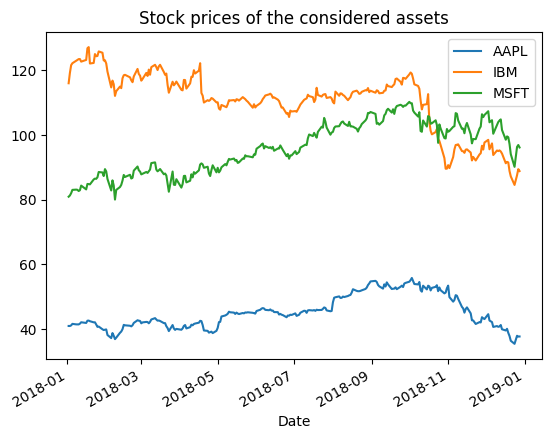

In [6]:
prices_df = yf.download(RISKY_ASSETS, start = START_DATE,
                        end = END_DATE, adjusted = True)

print(f'Downloaded {prices_df.shape[0]} rows of data.')
prices_df['Adj Close'].plot(title='Stock prices of the considered assets')

plt.show()

4. 각 자산 수익률을 계산

In [7]:
returns = prices_df['Adj Close'].pct_change().dropna()

In [9]:
returns.head()

,AAPL,IBM,MSFT
Date,,,
2018-01-03,-0.000174,0.027488,0.004654
2018-01-04,0.004645,0.020254,0.008801
2018-01-05,0.011385,0.004886,0.012398
2018-01-08,-0.003714,0.006031,0.001021
2018-01-09,-0.000115,0.002202,-0.000680


5. weight를 정의하기

In [11]:
portfolio_weights = n_assets * [1 / n_assets]

6. 포트폴리오 수익률 계산하기

In [12]:
portfolio_returns = pd.Series(np.dot(portfolio_weights, returns.T),
                                     index = returns.index)

In [13]:
portfolio_returns 

Date
2018-01-03    0.010656
2018-01-04    0.011233
2018-01-05    0.009556
2018-01-08    0.001113
2018-01-09    0.000469
                ...   
2018-12-21   -0.029871
2018-12-24   -0.032663
2018-12-26    0.058081
2018-12-27    0.007044
2018-12-28   -0.004629
Length: 249, dtype: float64

/Users/jw/Library/Python/3.9/lib/python/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Users/jw/Library/Python/3.9/lib/python/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2018-01-03
End date,2018-12-28
Total months,11
,Backtest
Annual return,-4.8%
Cumulative returns,-4.8%
Annual volatility,23.3%
Sharpe ratio,-0.10
Calmar ratio,-0.17
Stability,0.12
Max drawdown,-27.9%


/Users/jw/Library/Python/3.9/lib/python/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


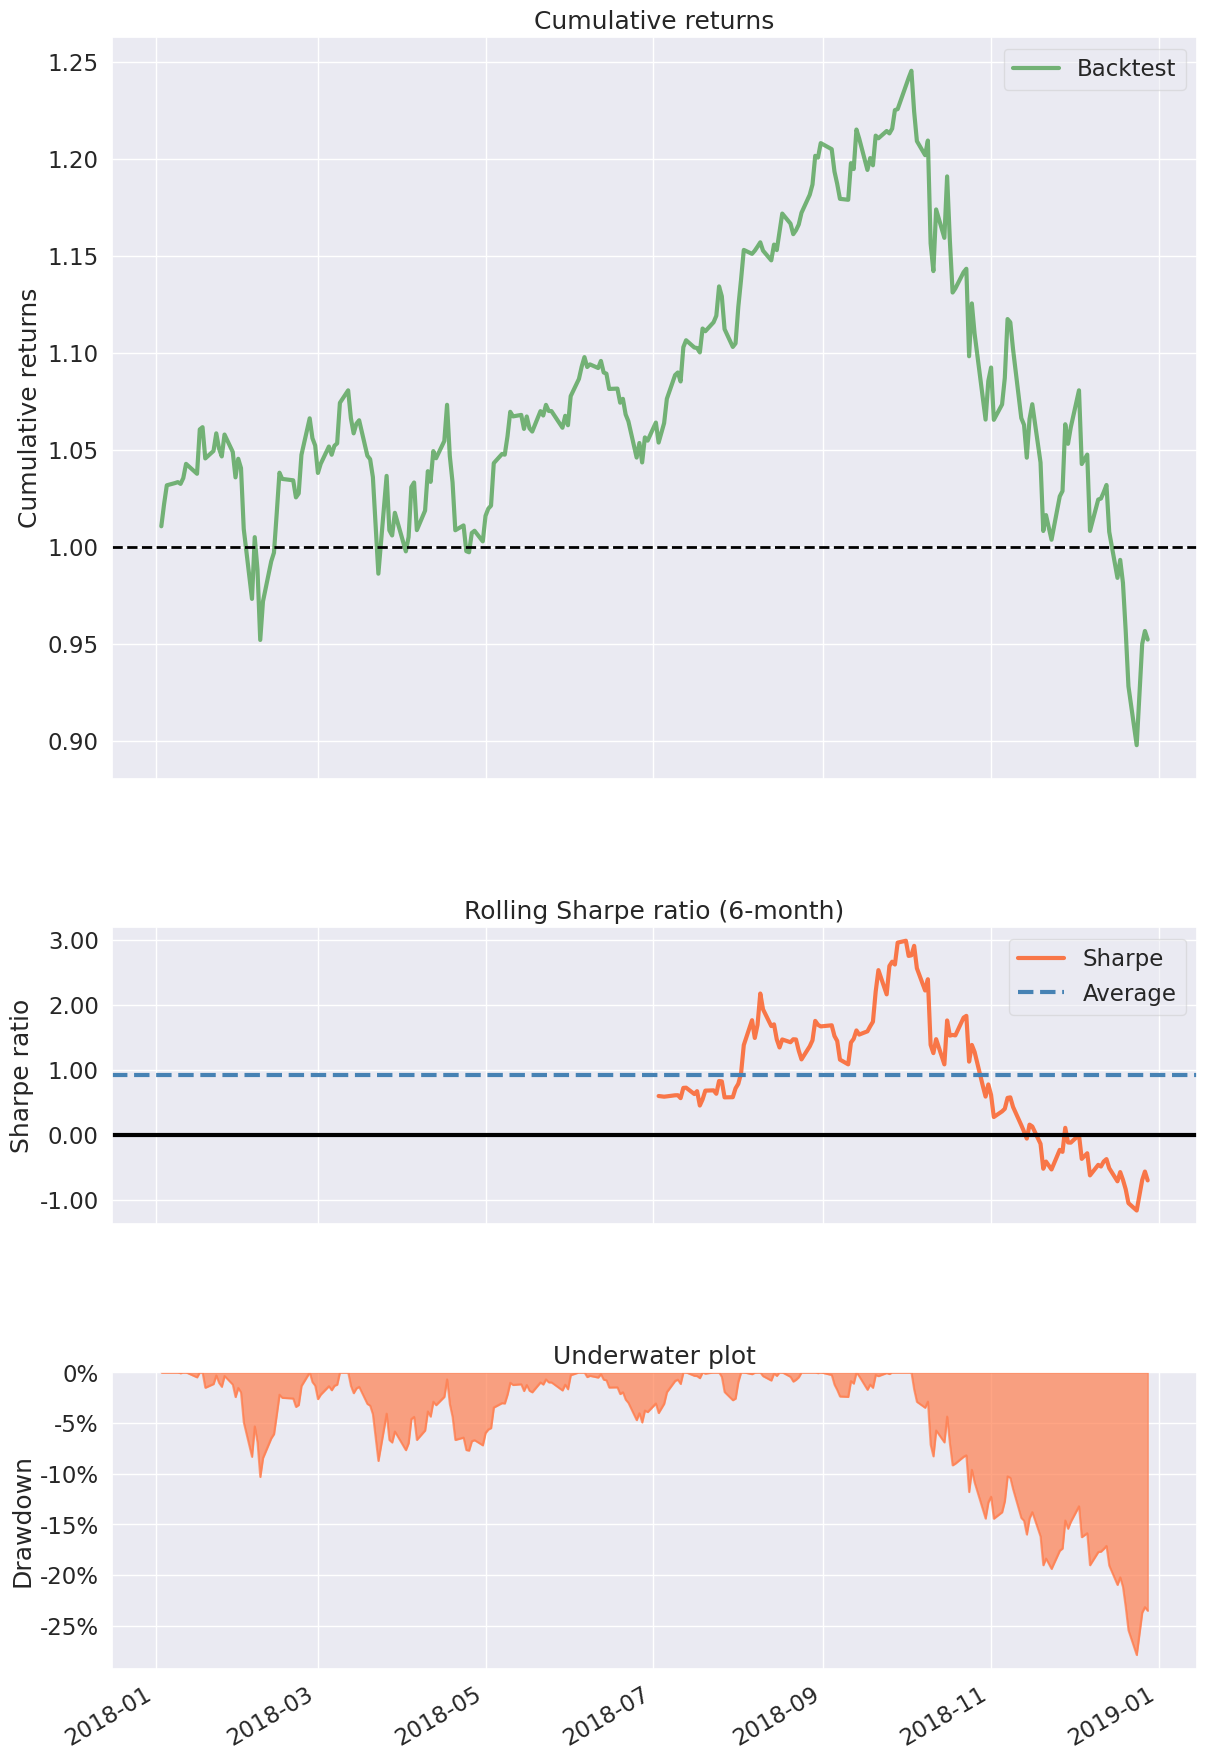

In [15]:
pf.create_simple_tear_sheet(portfolio_returns)

## efficient frontier 찾기

In [18]:
N_PORTFOLIOS = 10 ** 5 
N_DAYS = 252 

In [16]:
prices_df.shape[0]

250

<AxesSubplot: title={'center': 'stock prices of the considered assetes'}, xlabel='Date'>

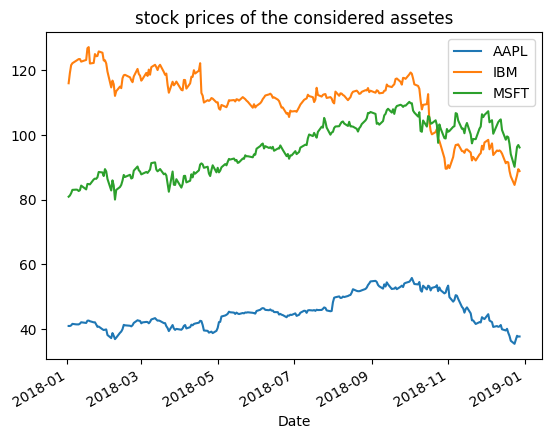

In [17]:
prices_df['Adj Close'].plot(title = 'stock prices of the considered assetes')

4. 연평균 수익률 계산하기, 표준편차 구하기

In [19]:
returns_df = prices_df['Adj Close'].pct_change().dropna()

avg_returns = returns_df.mean() * N_DAYS
cov_mat = returns_df.cov() * N_DAYS

1. avg_returns
* AAPL   -0.042448
* IBM    -0.239029
* MSFT    0.214581

2. cov_mat

In [21]:
cov_mat

,AAPL,IBM,MSFT
AAPL,0.082850,0.034488,0.056948
IBM,0.034488,0.060970,0.041520
MSFT,0.056948,0.041520,0.080394


* 일간 수익률로 변환

<AxesSubplot: title={'center': 'daily returns of the considered assets'}, xlabel='Date'>

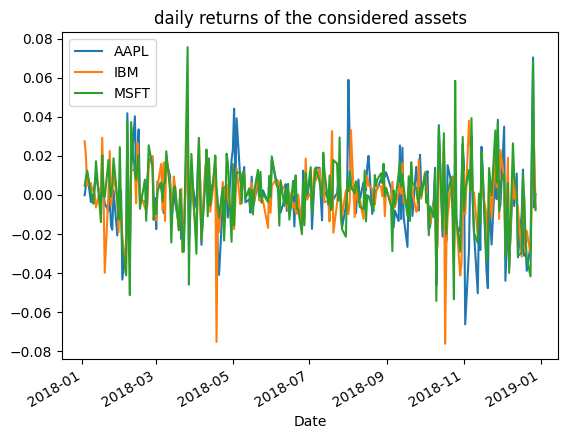

In [22]:
returns_df.plot(title = 'daily returns of the considered assets')

5. 랜덤 포트폴리오 가중치를 시뮬레이트

In [23]:
np.random.seed(42)

weights = np.random.random(size = (N_PORTFOLIOS, n_assets))

weights /= np.sum(weights, axis = 1)[:, np.newaxis]

In [24]:
weights

array([[0.18205878, 0.46212909, 0.35581214],
       [0.65738127, 0.17132261, 0.17129612],
       [0.03807826, 0.56784481, 0.39407693],
       ...,
       [0.15312135, 0.49415067, 0.35272797],
       [0.53306335, 0.06032037, 0.40661627],
       [0.45463344, 0.0345693 , 0.51079726]])

In [33]:
  portf_rtns = np.dot(weights,avg_returns)

  portf_vol = []
  for i in range(0, len(weights)): 
      portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                      np.dot(cov_mat, weights[i]))))
  

  portf_vol = np.array(portf_vol) 
  portf_sharpe_ratio = portf_rtns / portf_vol

In [34]:
portf_rtns

array([-0.04183994, -0.03209869, -0.05278654, ..., -0.04892751,
        0.05020633,  0.08204602])

In [35]:
portf_results_df = pd.DataFrame({'returns': portf_rtns, 
                                 'volatility': portf_vol, 
                                 'sharpe_ratio': portf_sharpe_ratio})

portf_results_df 

,returns,volatility,sharpe_ratio
0,-0.041840,0.229741,-0.182118
1,-0.032099,0.250964,-0.127901
2,-0.052787,0.232481,-0.227058
3,0.101937,0.262019,0.389046
4,-0.038378,0.251882,-0.152364
...,...,...,...
99995,0.061836,0.245997,0.251370
99996,0.049962,0.250287,0.199618
99997,-0.048928,0.229515,-0.213177
99998,0.050206,0.256901,0.195431


In [36]:
N_POINTS = 100 
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                            N_POINTS)

portf_rtns_ef = np.round(portf_rtns_ef, 2)
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(N_POINTS): 
    if portf_rtns_ef[point_index] not in portf_rtns: 
        indices_to_skip.append(point_index) 
        continue 
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index]) 
    # return elements chosen from x or y depending on condition
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))

portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)

8. efficient frontier 를 만들고 포인트 위치

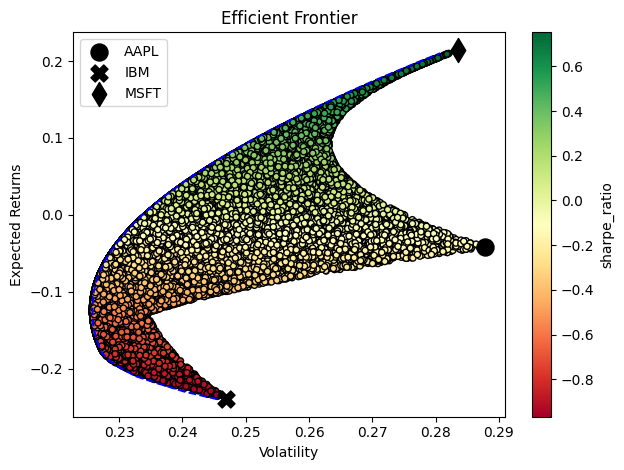

In [37]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=RISKY_ASSETS[asset_index])
ax.legend()

plt.tight_layout()
plt.show()

### there's more

In [38]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)

max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)

min_vol_portf = portf_results_df.loc[min_vol_ind]

In [39]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
returns: 21.28% volatility: 28.30% sharpe_ratio: 75.20% 
Weights
AAPL: 0.19% IBM: 0.29% MSFT: 99.52% 

* 최대 sharpe ratio 자산 배분
1. AAPL 0.19%
1. IBM 0.29%
1. MSFT 99.52%

In [40]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(RISKY_ASSETS, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: -12.38% volatility: 22.58% sharpe_ratio: -54.84% 
Weights
AAPL: 28.08% IBM: 58.69% MSFT: 13.22% 

* 최소 volatility 자산 배분
1. AAPL 28.08%
2. IBM 58.69%
3. MSFT 13.22%

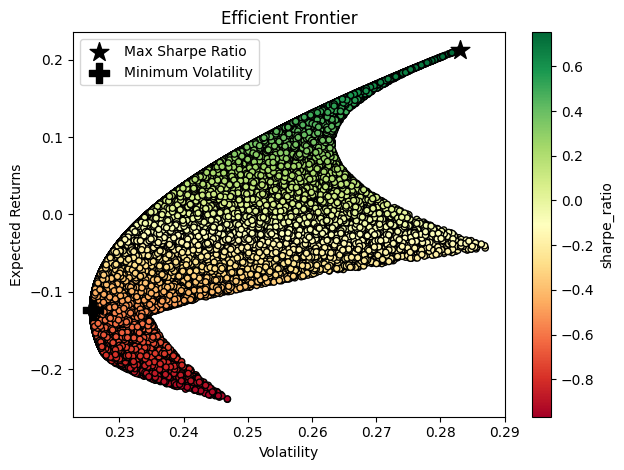

In [41]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')

ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
           
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.show()

* 최대 sharpe ratio 자산 배분
1. AAPL 0.19%
1. IBM 0.29%
1. MSFT 99.52%

* 최소 volatility 자산 배분
1. AAPL 28.08%
2. IBM 58.69%
3. MSFT 13.22%

# HW4 - numerical simulation

In [45]:
RISKY_ASSET_1 = 'AAPL'
RISKY_ASSET_2 = 'IBM'
RISKY_ASSET_3 = 'MSFT'

In [46]:
df_1 = yf.download(RISKY_ASSET_1, start=START_DATE, 
                 end=END_DATE, adjusted=True)

df_2 = yf.download(RISKY_ASSET_2, start=START_DATE, 
                 end=END_DATE, adjusted=True)

df_3 = yf.download(RISKY_ASSET_3, start=START_DATE, 
                 end=END_DATE, adjusted=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [47]:
def cal_day_rtn(df, risky_asset) :
    adj_close = df['Adj Close']
    returns = adj_close.pct_change().dropna()

    ax = returns.plot()
    ax.set_title(f'{risky_asset} retunrns {START_DATE} - {END_DATE}',
                    fontsize = 16)
    
    plt.tight_layout()
    plt.show()

    print(f'Average return : {100 * returns.mean():.2f}%')


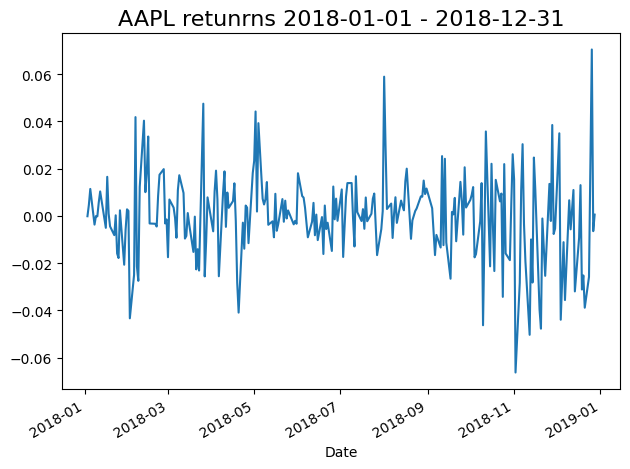

Average return : -0.02%


In [48]:
cal_day_rtn(df_1, RISKY_ASSET_1)

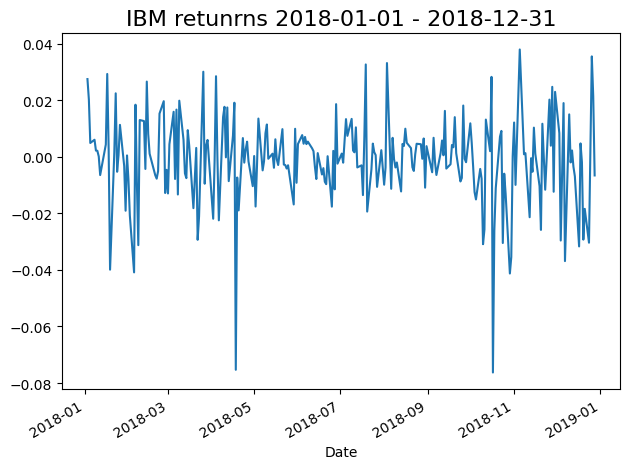

Average return : -0.09%


In [49]:
cal_day_rtn(df_2, RISKY_ASSET_2)

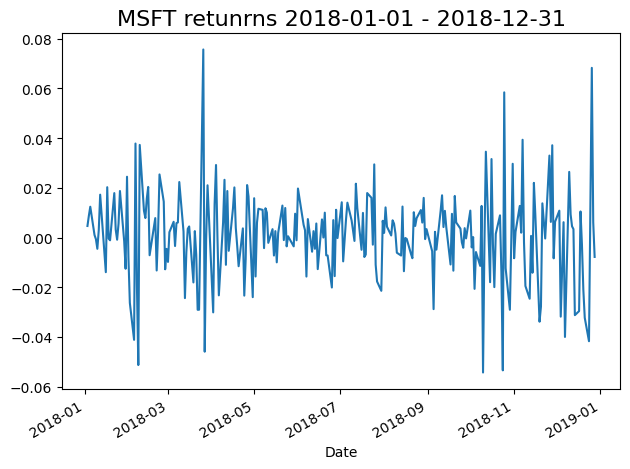

Average return : 0.09%


In [50]:
cal_day_rtn(df_3, RISKY_ASSET_3)

### 평균 수익률
1. AAPL : -0.02%
1. IBM : -0.09%
1. MSFT : 0.09%

In [51]:
adj_close_1 = df_1['Adj Close']
returns_1 = adj_close_1.pct_change().dropna()

adj_close_2 = df_2['Adj Close']
returns_2 = adj_close_2.pct_change().dropna()

adj_close_3 = df_3['Adj Close']
returns_3 = adj_close_3.pct_change().dropna()


In [52]:
train_1 = returns_1['2018-01-01' : '2018-06-30']
test_1 = returns_1['2018-07-01' : '2018-07-31']

train_2 = returns_2['2018-01-01' : '2018-06-30']
test_2 = returns_2['2018-07-01' : '2018-07-31']

train_3 = returns_3['2018-01-01' : '2018-06-30']
test_3 = returns_3['2018-07-01' : '2018-07-31']

In [53]:
T_1 = len(test_1)
N_1 = len(test_1) 
s_0_1 = adj_close_1[train_1.index[-1]]
N_SIM_1 = 100 
mu_1 = train_1.mean()
sigma_1 = train_1.std()

T_2 = len(test_2)
N_2 = len(test_2) 
s_0_2 = adj_close_2[train_2.index[-1]]
N_SIM_2 = 100 
mu_2 = train_2.mean()
sigma_2 = train_2.std()

T_3 = len(test_3)
N_3 = len(test_3) 
s_0_3 = adj_close_3[train_3.index[-1]]
N_SIM_3 = 100 
mu_3 = train_3.mean()
sigma_3 = train_3.std()

In [54]:
def simulate_gbm(s_0, mu, sigma, n_sims, T, N, 
                 random_seed=42):
    np.random.seed(random_seed)

    dt = T/N 
    dW = np.random.normal(scale = np.sqrt(dt), size=(n_sims, N))
    W = np.cumsum(dW, axis =1)

    time_step = np.linspace(dt, T, N)
    time_steps = np.broadcast_to(time_step, (n_sims, N))

    S_t = s_0 * np.exp((mu - 0.5 * sigma ** 2) * time_steps
                       + sigma * W)
    S_t = np.insert(S_t, 0, s_0, axis=1)

    return S_t

In [55]:
gbm_simulations_1 = simulate_gbm(s_0_1, mu_1, sigma_1, N_SIM_1, T_1, N_1)

gbm_simulations_2 = simulate_gbm(s_0_2, mu_2, sigma_2, N_SIM_2, T_2, N_2)

gbm_simulations_3 = simulate_gbm(s_0_3, mu_3, sigma_3, N_SIM_3, T_3, N_3)

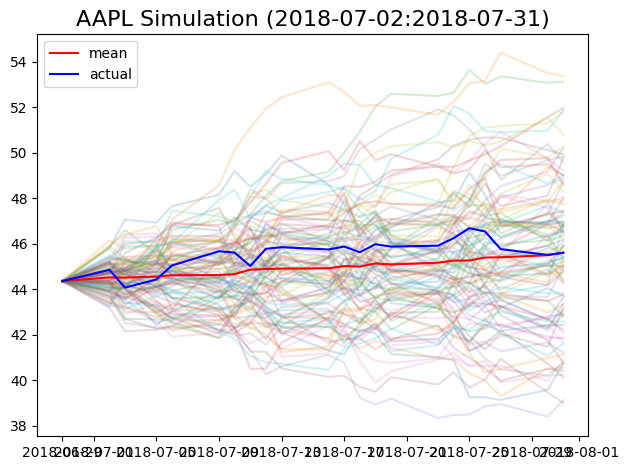

In [57]:
# prepare objects for plotting AAPL
last_train_date = train_1.index[-1].date()
first_test_date = test_1.index[0].date()
last_test_date = test_1.index[-1].date()
plot_title = (f'{RISKY_ASSET_1} Simulation '
              f'({first_test_date}:{last_test_date})')

selected_indices = adj_close_1[last_train_date:last_test_date].index
index = [date.date() for date in selected_indices]

gbm_simulations_df = pd.DataFrame(np.transpose(gbm_simulations_1), 
                                  index=index)

# plotting
ax = gbm_simulations_df.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index, gbm_simulations_df.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index, adj_close_1[last_train_date:last_test_date], 
                  color='blue')
ax.set_title(plot_title, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()

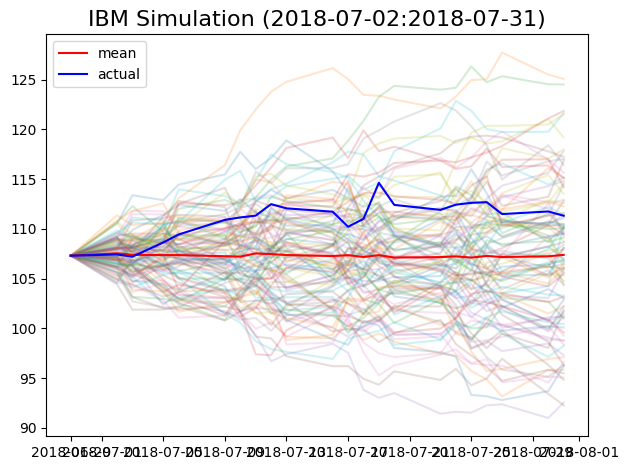

In [60]:
# prepare objects for plotting IBM
last_train_date_2 = train_2.index[-1].date()
first_test_date_2 = test_2.index[0].date()
last_test_date_2 = test_2.index[-1].date()
plot_title_2 = (f'{RISKY_ASSET_2} Simulation '
              f'({first_test_date_2}:{last_test_date_2})')

selected_indices_2 = adj_close_2[last_train_date_2 : last_test_date_2].index
index_2 = [date.date() for date in selected_indices_2]

gbm_simulations_df_2 = pd.DataFrame(np.transpose(gbm_simulations_2), 
                                  index=index_2)

# plotting
ax = gbm_simulations_df_2.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index_2, gbm_simulations_df_2.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index_2, adj_close_2[last_train_date_2 : last_test_date_2], 
                  color='blue')
ax.set_title(plot_title_2, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()

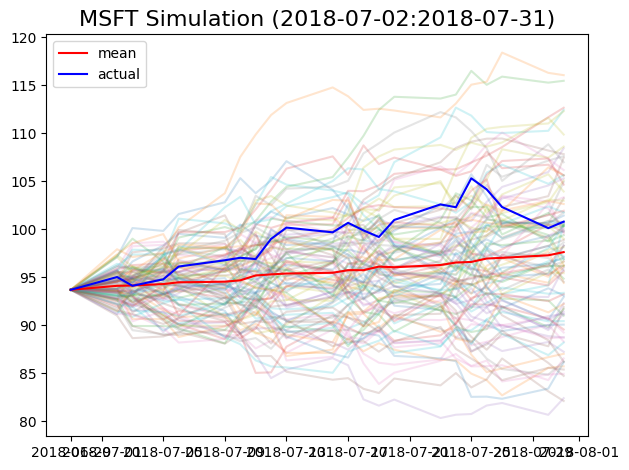

In [61]:
# prepare objects for plotting IBM
last_train_date_3 = train_3.index[-1].date()
first_test_date_3 = test_3.index[0].date()
last_test_date_3 = test_3.index[-1].date()
plot_title_3 = (f'{RISKY_ASSET_3} Simulation '
              f'({first_test_date_3}:{last_test_date_3})')

selected_indices_3 = adj_close_3[last_train_date_3 : last_test_date_3].index
index_3 = [date.date() for date in selected_indices_3]

gbm_simulations_df_3 = pd.DataFrame(np.transpose(gbm_simulations_3), 
                                  index=index_3)

# plotting
ax = gbm_simulations_df_3.plot(alpha=0.2, legend=False)
line_1, = ax.plot(index_3, gbm_simulations_df_3.mean(axis=1), 
                  color='red')
line_2, = ax.plot(index_3, adj_close_3[last_train_date_3 : last_test_date_3], 
                  color='blue')
ax.set_title(plot_title_3, fontsize=16)
ax.legend((line_1, line_2), ('mean', 'actual'))

plt.tight_layout()
#plt.savefig('images/ch6_im2.png')
plt.show()